In [1]:
import numpy as np
import random
import copy
import math
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from scipy.spatial import ConvexHull, convex_hull_plot_2d

fittest_swarm = None
num_drones = 25
drone_id = 0
population = []
map_length = 150
map_width = 150
generations = 300
battery_life = 500
members_per_generation = 3
patience = 75

fittest_swarm_list = [[0],[0]]

In [2]:
# Class to represent a drone.
# id - drone's numerical ID
# x, y - coordinates of where the drone is
# x_move, y_move - the outputs of the neural network that control the direction the drones move
# coverage - the radius of the circular search area that the drone covers
# rely_on - the drone that self relies on for positioning. If the signal with this drone is too weak, self "dies"
# send_to - the drone that relies on self for positioning
# connected_to - list of drones that self is connected to
# is_alive - "alive" (True) when self is close enough to rely_on for signal, "dead" (False) otherwise
# nn - the neural network of this drone
class Drone:
    id = 0
    x = 0
    y = 0
    x_move = 0
    y_move = 0
    unsearched_N = 0
    unsearched_S = 0
    unsearched_W = 0
    unsearched_E = 0
    coverage = 10
    rely_on = None
    send_to = None
    connected_to = []
    is_alive = True
    nn = None
    swarm = None # drone knows what swarm it belongs to
    path = []
    actions = []
    
    # Initialize self variables
    def __init__(self):
        # Assign self id
        global drone_id
        self.id = drone_id
        drone_id += 1
        
        # Instantiate other self vars
        self.path = [[],[]]
        self.actions = [[],[]]
        
        self.connected_to = []
        self.rely_on = None
        self.send_to = None
        self.nn = None
        self.swarm = None
        
        self.unsearched_N = 1
        self.unsearched_S = 1
        self.unsearched_W = 1
        self.unsearched_E = 1
        
    # When printing drone object, it prints the drone's numerical id
    def __repr__(self):
        return str(self.id)
    
    def move(self, x_adj, y_adj):
        cancel = False
        for neighbor in self.connected_to:
            if coordinate_sig_strength(self.x + x_adj, neighbor.x, self.y + y_adj, neighbor.y) > 30:
                cancel = True

        # Move the drone based on the nn results        
        if not cancel:
            self.x += x_adj
            self.y += y_adj
            self.actions[0].append(x_adj)
            self.actions[1].append(y_adj)
            self.path[0].append(self.x)
            self.path[1].append(self.y)
    
    # Create and initialize the neural network
    def neural_init(self):
        self.nn = NeuralNetwork(self.get_input_layer())
    
    # Interprets what the input layer for the neural network should be at the time the func is called
    def get_input_layer(self):
        # Gets the signal strength between important drone connections. -1 if connection doesn't exist
        rely_on_sig = -1
        #print(self, "relies on", self.rely_on)
        if self.rely_on != None:
            rely_on_sig = drone_sig_strength(self, self.rely_on)
        
        #print(self, "sends to", self.send_to)
        send_to_sig = -1
        if self.send_to != None:
            send_to_sig = drone_sig_strength(self, self.send_to)
        
        #self.sense_surroundings()
        
        # Assembles the input layer using variables.
        #in_layer = [self.x, self.y, rely_on_sig, send_to_sig, self.x_move, self.y_move, self.unsearched_N*50, self.unsearched_S*50, self.unsearched_E*50, self.unsearched_W*50]
        in_layer = [self.x, self.y, rely_on_sig, send_to_sig, self.x_move, self.y_move]
        #in_layer = [sigmoid(self.x*5), sigmoid(self.y*5), sigmoid(rely_on_sig), sigmoid(send_to_sig), self.x_move, self.y_move]
        #out_layer_form = np.array([[0],[0],[0],[0]])
        in_layer = np.array([in_layer])
        #self.nn = NeuralNetwork(in_layer, out_layer_form)
        return in_layer
    
    # Feedforward the neural network. aka Find the output layer given an input_layer
    # Get input layer from get_input_layer()
    def neural_net_feedforward(self, input_layer):
        #print(input_layer)
        movement = self.nn.feedforward(input_layer)
        #print(self, movement)
        self.x_move = movement[0][0]
        self.y_move = movement[0][1]
        
    def sense_surroundings(self):
        sense = self.coverage + 1
        if int(self.x) + sense <= self.swarm.the_map.length and not self.swarm.the_map.search_points[int(self.x) + sense][int(self.y)][0]:
            self.unsearched_E = 1
        else:
            self.unsearched_E = 0
            
        if int(self.x) - sense >= 0 and not self.swarm.the_map.search_points[int(self.x) - sense][int(self.y)][0]:
            self.unsearched_W = 1
        else:
            self.unsearched_W = 0
            
        if int(self.y) + sense <= self.swarm.the_map.width and not self.swarm.the_map.search_points[int(self.x)][int(self.y) + sense][0]:
            self.unsearched_N = 1
        else:
            self.unsearched_N = 0
            
        if int(self.y) - sense >= 0 and not self.swarm.the_map.search_points[int(self.x)][int(self.y) - sense][0]:
            self.unsearched_S = 1
        else:
            self.unsearched_S = 0

In [3]:
# Function to turn any number into a number between 0 and 1
# Use a sine function because other functions didn't have enough variation in the output
# https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6 
def sigmoid(x):
    #print(x, '\n')
    #return 2*((1.0/(1+ np.exp(-0.5*(x-1)))-0.5))
    #return (np.sin(x)+1)*.5
    #return np.sin(math.pi * x - math.pi/2.0)
    return np.sin(math.pi * x - math.pi/2.0) * .5 +.5
    #return ((np.tanh(.05*(x-50))+1)*.5)

# Neural network class
class NeuralNetwork:
    # Weights between layers are randomly created
    def __init__(self, x):
        self.input      = x
        # 4 layers, 6 -> 4 -> 8 -> 2
        self.weights = [None] * 3
        self.weights[0]   = np.random.rand(self.input.shape[1], 4)
        self.weights[1]   = np.random.rand(4, 7)  
        self.weights[2]   = np.random.rand(7, 2)  
        
        #self.output = np.zeros(y.shape)
    
    # Input layer is fedforward through the nn and output layer is calculated
    def feedforward(self, input_layer):
        self.hidden_layers = [None] * 2
        #For simplicity, biases are assumed to be zero
        self.hidden_layers[0] = sigmoid(np.dot(input_layer, self.weights[0]))
        self.hidden_layers[1] = sigmoid(np.dot(self.hidden_layers[0], self.weights[1]))
        self.output = sigmoid(np.dot(self.hidden_layers[1], self.weights[2]))
        #print(self.output)
        return self.output

In [4]:
# used to get starting points for drones.
# n - number of drones/points
# r - radius of polygon/how far spread out they should be
# map_size - the size of the map the points will be plotted on (to put tha points in the center)
# returns - vertices, which is a 2 element long array. 
#    Element [0] is an array of all the x-component of points
#    Element [1] is an array of all the y-component of points
#    The same indices in each x and y list represent different components of the same point
#    Example: point 2's x value is at x[2] and the y value is at y[2]
def vertices_of_regpoly(n, r, map_length, map_width):
    vertices = []
    x = []
    y = []
    for i in range(0, n):
        x.append(( map_length / 2) + r * math.cos(2 * math.pi * i / n))
        y.append(( map_width /  2) + r * math.sin(2 * math.pi * i / n))
    vertices.append(x)
    vertices.append(y)
    return vertices

In [5]:
# Set each drone's initial locations to the drone's self.x and self.y values
def set_init_drones(swarm):
    xy = vertices_of_regpoly(num_drones, 2, swarm.the_map.length, swarm.the_map.width)
    for i in range(0, len(swarm.drones)):
        swarm.drones[i].x = xy[0][i]
        swarm.drones[i].y = xy[1][i]
        swarm.drones[i].x_move = 0
        swarm.drones[i].y_move = 0
        swarm.drones[i].is_alive = True
        swarm.drones[i].swarm = swarm

In [6]:
# The swarm class is a collection of drones
# It is also the "organism" unit of the population list, used in the Genetic Algorithm component of the program
# drones - list of drones in the population
# connectedness - matrix representing how the drones are connected to each other
class Swarm:
    drones = []
    connectedness = []
    fitness = 0
    battery_life = 0 # simulates a time limit to search an area
    battery_left = 0
    
    # Initialize the swarm
    def __init__(self, drones, map_length, map_width):
        global battery_life
        self.battery_life = battery_life
        self.battery_left = self.battery_life
        self.fitness = 0
        self.the_map = GeoMap(map_length, map_width) # The map to search
        self.drones = drones # the list of drones
        global drone_id # Reset the drone id counter for every swarm 
        drone_id = 0
        set_init_drones(self) # Set each drone's initial locations
        self.assign_connectedness()
        #self.use_hard_coded_connectedness()
        self.assign_drone_connect()
        self.rssi_table = []
        determine_architecture(self)
        determine_neighbors(self)
        for drone in self.drones:
            drone.neural_init()
    
    def __repr__(self):
        return str(self.fitness)
    
    def reset(self):
        self.battery_left = self.battery_life
        self.fitness = 0
        self.the_map = GeoMap(map_length, map_width) # The map to search
        set_init_drones(self) # Set each drone's initial locations
            
    # Randomly assign how the drones are connected to each other
    def assign_connectedness(self):
        #Make the swarm's connectivity matrix
        #This matrix is really only used for initial configuration
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        self.connectedness = np.zeros((len(self.drones),len(self.drones)))

        #The upper traingle of a mtrix w/o diagonal is filled in with 1s
        #the diagonal would mean drones are connected to themselves
        #the lower triangle is just a reflection
        #representation of the connections between drones
        for i in range(0,len(self.drones)):
            for j in range(0, i):
                self.connectedness[j][i] = 1

        # Ensure that each drone has at least one connection
        for i in range(0,len(self.drones)):
            possible_values = np.nonzero(self.connectedness[i])[0].tolist()
            choice = random.choice(possible_values) if possible_values else -1
            if choice != -1:
                possible_values.remove(choice)
            #Remaining choices have a possibility of not being connections (probability related to the number of drones)
            for value in possible_values:
                self.connectedness[i][value] = 0 if random.random() > 1.0/float(len(self.drones)) else 1

        #reflect over diagonal axis of matrix to make symmetric matrix
        for i in range(0,len(self.drones)):
            for j in range(0, i):
                self.connectedness[i][j] = self.connectedness[j][i]
                
    def use_hard_coded_connectedness(self):
        self.connectedness = np.zeros((len(self.drones),len(self.drones)))
        for i in range(0, len(self.drones)):
            for j in range (0, i):
                if j + 1 == i:
                    self.connectedness[j][i] = 1
    
    # After the swarm's connectedness is determines, each drone is told which drones it is connected to
    def assign_drone_connect(self):
        #Assign list connectedness in drones
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        for i in range(0,len(self.connectedness)):
            for j in range(0, len(self.connectedness)):
                if self.connectedness[i][j] == 1:
                    self.drones[i].connected_to.append(self.drones[j])
    
    # Determine the fitness of the swarm for purposes of evolution 
    # Fitness function takes all of these factors into account for spread:
    # Calculated area from vertices, each drone's distance from the center, drones' signal strength to each other,
    # search points when stationary, search points searched when traveling
    def determine_fitness(self):
        x = []
        y = []
        for drone in self.drones:
            x.append(drone.x)
            y.append(drone.y)
        #self.fitness += polygon_area(x,y) * .5
        #self.fitness += max_width_of_swarm_polygon(self.drones) * 100
#         for drone in self.drones:
#             for neighbor in drone.connected_to:
#                 self.fitness += drone_sig_strength(drone, neighbor)

        for i in range(0, len(self.drones)):
            drone_fitness = 1
            for j in range(i + 1, len(self.drones)):
                drone_fitness += drone_sig_strength(self.drones[i], self.drones[j])/num_drones
            self.fitness += drone_fitness

#         for i in range(0, len(self.drones)):
#             drone_fitness = 1
#             for j in range(0, len(drone.connected_to)):
#                 drone_fitness *= drone_sig_strength(self.drones[i], drone.connected_to[j])/num_drones
#             self.fitness += drone_fitness
                
    
    def search_percentage(self):
        return float(self.fitness)/float(self.the_map.get_total_points()) * 100

In [7]:
def polygon_area(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [8]:
def max_width_of_swarm_polygon(drones):
#     points = np.zeros(shape=(len(drones),2))
#     for i in range(0,len(drones)):
#         points[i][0] = drones[i].x
#         points[i][1] = drones[i].y
#     hull = ConvexHull(points)
    
#     plt.plot(points[:,0], points[:,1], 'o')
#     plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
#     plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')
#     plt.show()

#     max_diag = 0
#     for i in range(0, len(hull.vertices)):
#         for j in range(i + 1, len(hull.vertices)):
#             drone1x = points[hull.vertices[i],0]
#             drone1y = points[hull.vertices[i],1]
#             drone2x = points[hull.vertices[j],0]
#             drone2y = points[hull.vertices[j],1]
#             diagonal = abs(math.hypot(drone2x - drone1x, drone2y - drone1y))
#             if diagonal > max_diag:
#                 max_diag = diagonal
#     return max_diag

    max_diag = 0
    for i in range(0, len(drones)):
        for j in range(i + 1, len(drones)):
            diagonal = abs(math.hypot(drones[j].x - drones[i].x, drones[j].y - drones[i].y))
            if diagonal > max_diag:
                max_diag = diagonal
    return max_diag

In [9]:
# This map class represents a geographical area that must be searched by a  swarm
# search_points - points in the map that will be checked if they have been searched or not. Represented by a matrix of booleans
class GeoMap:
    search_points = []
    #searched_points = set() # NOT CURRENTLY USED
    # Was explored as an alternative method to search points. Was just a list of points of where drones have been.
    def __init__(self, length, width):
        self.length = length
        self.width = width
        self.search_points = []
        self.populate_search_points()
    
    # Create a visualization of the map border
    def draw_map(self):
        plt.plot([0, 0,          self.length, self.length, 0], 
                 [0, self.width, self.width,  0,           0])
        self.disp_search_points()
        #self.disp_searched_points()
    
    # Create a visualization of which points in search_points have been searched
    def disp_search_points(self):
        for x in range(0, len(self.search_points)):
            for y in range(0, len(self.search_points[x])):
                if self.search_points[x][y][0]:
                    plt.plot(x, y, '.', color=self.search_points[x][y][1])
    
    # NOT CURRENTLY USED
    #def disp_searched_points(self):
        #for point in self.searched_points:
            #plt.plot(point[0], point[1], '.', color='green')
    
    # Initialize the map of search points
    def populate_search_points(self):
        for i in range(0, self.length + 2):
            row = []
            for j in range(0, self.width + 2):
                row.append([False, '#00FF00'])
            self.search_points.append(row)
            
    def get_total_points(self):
        return self.length * self.width

In [10]:
# Determine the architecture of the swarm in terms of which drone relies on which for positioning and communication
# Architecture is determined maximize the signal strength read between drones 
# (drones farther away from each other initially will not attempt to talk to each other directly)
def determine_architecture(swarm):
    coordinator = None
    for drone in swarm.drones:
        if coordinator == None:
            coordinator = drone
            rssi = 0
        else:
            rssi = drone_sig_strength(drone, coordinator)
        init_rssi_table(drone, rssi, swarm.rssi_table)
    sort_table_by_rssi(swarm.rssi_table)

In [11]:
# Initialize the signal strength table
def init_rssi_table(node_check, rssi, rssi_table):
    node = {}
    node["node"] = node_check
    node["rssi"] = rssi
    rssi_table.append(node)

In [12]:
# Sort the signal strength table
def sort_table_by_rssi(rssi_table):
    rssi_table.sort(key=lambda val: val["rssi"])

In [13]:
# Drones determine who they should rely_on for communication and who they should send_to 
# This is determined based o nthe ordering of the sorted signal-strength-architecture table
def determine_neighbors(swarm):
    if len(swarm.rssi_table) > 1:
        for index in range(0, len(swarm.rssi_table)):
            node = swarm.rssi_table[index]['node']
            if index == 0:
                node.rely_on = None
                node.send_to = swarm.rssi_table[index + 1]['node']
            elif index == len(swarm.rssi_table) - 1:
                node.rely_on = swarm.rssi_table[index - 1]['node']
                node.send_to = None
            else:
                node.rely_on = swarm.rssi_table[index - 1]['node']
                node.send_to = swarm.rssi_table[index + 1]['node']

In [14]:
# Create a starting population (generation 1) for the genetic algorithm
# size - how many members of the population should be created
# map_size - the size of the map of the world that the population should be simulated in
def create_starting_population(size, map_length, map_width):
    population = []
    
    global num_nodes
    for i in range(0,size):
        population.append(create_new_member([], map_length, map_width))
        
    return population

In [15]:
# Creates a new member of a population
# drones - list of drones for the population-member (swarm) (if list empty, drones will be created)
# map_size - the size of the map of the world that the population should be simulated in
def create_new_member(drones, map_length, map_width):
    if drones == []:
        global num_drones
        for i in range(0, num_drones):
            drones.append(Drone())
    member = Swarm(drones, map_length, map_width)
    return member

In [16]:
# Display a visualization of a swarm
def plot_swarm(swarm):
    fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
    for drone in swarm.drones:
        xs = []
        ys = []
        plt.plot(drone.x, drone.y, 'x', color='black')
        xs.append(drone.x)
        ys.append(drone.y)
    
        for x, y in zip(xs, ys):
            plt.text(x, y, str(drone.id), color="purple", fontsize=18)
    
        #print(drone.x, drone.y)
        #circle1 = plt.Circle((drone.x, drone.y), drone.coverage, color = 'b', fill=False)        
        #ax.add_artist(circle1)

    #fig.savefig('plotcircles.png')
        
    # Draws a visualization for the network connections    
    for row in range(0, num_drones - 1):
        for col in range(row + 1, num_drones):
            if swarm.connectedness[row][col] == 1:
                plt.plot([swarm.drones[row].x, swarm.drones[col].x], 
                         [swarm.drones[row].y, swarm.drones[col].y])

In [17]:
# Returns all the integer points that are within a given circle
# x0, y0 - the center of the circle
# radius - the radius of the circle
# NOT USED CURRENTLY
def points_in_circle(x0, y0, radius):
    x_ = np.arange(x0 - radius - 1, x0 + radius + 1, dtype=int)
    y_ = np.arange(y0 - radius - 1, y0 + radius + 1, dtype=int)
    x, y = np.where((x_[:,np.newaxis] - x0)**2 + (y_ - y0)**2 <= radius**2)
    # x, y = np.where((np.hypot((x_-x0)[:,np.newaxis], y_-y0)<= radius)) # alternative implementation
    for x, y in zip(x_[x], y_[y]):
        yield x, y
        plt.plot(x, y, '.', color='blue')

In [18]:
# Determine the distance between two drones
def drone_distance(drone1, drone2):
    return abs(math.hypot(drone2.x - drone1.x, drone2.y - drone1.y))

# Determine the signal strength between 2 drones using an RSSI formula
def drone_sig_strength(drone1, drone2):
    #return 20*math.log10(1/math.pow(drone_distance(drone1, drone2),2))
    #return 1/math.pow(drone_distance(drone1, drone2),2)
    dist = drone_distance(drone1, drone2)
    #print(dist)
    try:
        return  10*2*math.log10(dist) + 1
    except ValueError:
        return 0
    
def coordinate_distance(x1, x2, y1, y2):
    return abs(math.hypot(x2 - x1, y2 - y1))

def coordinate_sig_strength(x1, x2, y1, y2):
    dist = coordinate_distance(x1, x2, y1, y2)
    try:
        return  10*2*math.log10(dist) + 1
    except ValueError:
        return 0

# Determine the signal strength between all drones of an entire swarm
def swarm_sig_strength(swarm):
    swarm_strength = []
    
    for i in range(0, num_drones):
        for j in range(0, i):
            if swarm.connectedness[i][j] == 1:
                #print('Signal strength between drone ', i, ' and drone ', j, ': ', end='')
                #print(drone_sig_strength(swarm.drones[i], swarm.drones[j]))
                dist = drone_distance(swarm.drones[i], swarm.drones[j])
                sig_strength = drone_sig_strength(swarm.drones[i], swarm.drones[j])
                swarm_strength.append([[j, i], dist , sig_strength])
    return swarm_strength

In [19]:
# Check how many points in GeoMap's search_points have been searched
def check_drone_coverage(swarm):
    #Only check the points that are within the area that drones have been
    min_x = swarm.the_map.length + 1
    max_x = 0
    min_y = swarm.the_map.width + 1
    max_y = 0
    for drone in swarm.drones:
        if drone.x < min_x:
            min_x = drone.x
        if drone.x > max_x:
            max_x = drone.x
        if drone.y < min_y:
            min_y = drone.y
        if drone.y > max_y:
            max_y = drone.y
    
        #for circle_point in points_in_circle(drone.x, drone.y, drone.coverage):
            #the_map.searched_points.add(circle_point)

    #Check if points are within drone coverage
    for x in range(int(min_x - drone.coverage), int(max_x + drone.coverage) + 1):
        for y in range(int(min_y - drone.coverage), int(max_y + drone.coverage) + 1):
            for drone in swarm.drones:
                dist = math.sqrt(math.pow(x-drone.x, 2) + math.pow(y-drone.y, 2))
                if dist <= drone.coverage:
                    if x >= 0 and x <= swarm.the_map.length and y >= 0 and y <= swarm.the_map.width:
                        if not swarm.the_map.search_points[x][y][0]:
                            swarm.fitness += 1
                            swarm.the_map.search_points[x][y][0] = True
                        color = math.floor((swarm.battery_left/swarm.battery_life) * 255)
                        if color < 16:
                            swarm.the_map.search_points[x][y][1] = '#000' + str(hex(color))[2:] + '00'
                        else:
                            swarm.the_map.search_points[x][y][1] = '#00'  + str(hex(color))[2:] + '00'

    #print(swarm_sig_strength(swarm))
    #print(the_map.search_points)       

In [20]:
def search_area_limits(swarm):
    #Only check the points that are within the area that drones have been
    min_x = swarm.the_map.size + 1
    max_x = 0
    min_y = swarm.the_map.size + 1
    max_y = 0
    for drone in swarm.drones:
        if drone.x < min_x:
            min_x = drone.x
        if drone.x > max_x:
            max_x = drone.x
        if drone.y < min_y:
            min_y = drone.y
        if drone.y > max_y:
            max_y = drone.y
    return min_x, max_x, min_y, max_y

In [21]:
def check_coverage_population():
    for swarm in population:
        check_drone_coverage(swarm)

In [22]:
def set_map_size(ax=None):
    """ w, h: width, height in inches """
    w = .03*map_length
    h = .03*map_width
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [23]:
# Create a visualization of a swarm and the map it has searched
# swarm - the swarm to display
def draw_scene(swarm):
    plot_swarm(swarm)
    set_map_size()
    #swarm.the_map.draw_map()
    #print(swarm.search_percentage(), '%')
    print(swarm.fitness)

In [24]:
def plot_population():
    for swarm in population:
        draw_scene(swarm)
        #print(sorted(the_map.searched_points))
        #print(swarm_sig_strength(swarm))
        #print(swarm.fitness)
        #print(swarm.determine_fitness())

In [25]:
# Initialization of the main program
def init():
    global population
    global map_length
    global map_width
    global members_per_generation
    population = create_starting_population(members_per_generation, map_length, map_width)
    #check_coverage_population()
    plot_population()
    #for swarm in population:
        #determine_architecture(swarm)
        #determine_neighbors(swarm)

In [26]:
# Drones randomly move around with no intelligence to attempt to search an area
def scatter():
    for swarm in population:
        while swarm.battery_left > 0:
            for drone in swarm.drones:
                if drone.is_alive:
                    x_adj = 0
                    y_adj = 0
                    x_adj += random.randint(-1, 1)
                    y_adj += random.randint(-1, 1)
                    #for circle_point in points_in_circle(drone.x, drone.y, drone.coverage):
                        #print(circle_point)
                        #the_map.searched_points.add(circle_point)
                   
                    #if drone.x < 0 or drone.x > swarm.the_map.size or drone.y < 0 or drone.y > swarm.the_map.size:
                        #drone.is_alive = False
                        
                    # Move the drone based on the nn results
                    if drone.x + x_adj >= 0 and drone.x + x_adj <= swarm.the_map.length:
                        drone.x += x_adj
                    if drone.y + y_adj >= 0 and drone.y + y_adj <= swarm.the_map.width:
                        drone.y += y_adj

                    check_drone_coverage(swarm)
                    
                    # If the drone strayed too far away from it's neighbor's, the drone is dead
                    if drone.rely_on != None and drone_sig_strength(drone, drone.rely_on) > 30:
                        drone.is_alive = False

                    if drone.send_to != None and drone_sig_strength(drone, drone.send_to) > 30:
                        drone.is_alive = False
                        
                    #for neighbor in drone.connected_to:
                        #if drone_sig_strength(drone, neighbor) > 30:
                            #drone.is_alive = False
            swarm.battery_left -= 1 

In [27]:
def move_drone_neurally(drone):
    # Interpret neural network results
    if drone.x_move < 0.33:
        x_adj = -1
    elif drone.x_move >= 0.33 and drone.x_move < .66:
        x_adj = 0
    elif drone.x_move >= .66:
        x_adj = 1

    if drone.y_move < 0.33:
        y_adj = -1
    elif drone.y_move >= 0.33 and drone.y_move < .66:
        y_adj = 0
    elif drone.y_move >= .66:
        y_adj = 1

    drone.move(x_adj, y_adj)

    drone.neural_net_feedforward(drone.get_input_layer())

In [28]:
def tug_on_drones(drone):
    if drone.x >= map_length/2:
        x_adj = 1
    elif drone.x < map_length/2:
        x_adj = -1
        
    if drone.y >= map_width/2:
        y_adj = 1
    elif drone.y < map_width/2:
        y_adj = -1
        
    drone.move(x_adj, y_adj)
        

In [29]:
# Drones move around via neural network results to attempt to search an area
def smart_scatter():
    for swarm in population:
        while swarm.battery_left > 0:
            for drone in swarm.drones: 
                move_drone_neurally(drone)
                #tug_on_drones(drone)
            swarm.battery_left -= 1 
        #check_drone_coverage(swarm)
        swarm.determine_fitness()

In [30]:
def hard_coded_search():
    for swarm in population:
            for drone in swarm.drones:
                d = 1
                batteryyy = map_length * map_width
                while (batteryyy > 0):
                    batteryyy -= 1
                    if d == 1 and drone.x < map_length:
                        drone.x += 1
                    if d == 1 and drone.x == map_length:
                        drone.y += 1
                        d = -1
                    if d == -1 and drone.y > 0:
                        drone.x -= 1
                    if d == -1 and drone.x == 0:
                        drone.y += 1
                        d = 1
                    check_drone_coverage(swarm)

In [31]:
def kill_off_the_weak():
    for unfortunate_soul in range(math.floor(len(population)/2), len(population)):
        population.pop()

In [32]:
def check_for_fittest():
    global fittest_swarm
    if fittest_swarm == None or population[0].fitness > fittest_swarm.fitness:
        fittest_swarm = copy.deepcopy(population[0])
        #check_drone_coverage(fittest_swarm)
        #draw_scene(fittest_swarm)
        print("NEW FITTEST:", fittest_swarm.fitness)
        print(datetime.datetime.now() - start_time)
        return True
    else:
        if len(population) == 1:
            population[0] = copy.deepcopy(fittest_swarm)
        return False

In [33]:
# GA function to mate/breed organisms of the population together
# Done so by swapping drones with each other
def mingle_the_genes():
    global population
    
    # Assigning metaphorical sex. M/F assignment only metaphorical for separating groups
    males = []
    females = []
    
    random.shuffle(population)
    for i in range(0, len(population), 2):
        males.append(population[i])
    for i in range(1, len(population), 2):
        females.append(population[i])

    if len(females) == 0:
        asexually_reproduce()
        
    else:
        for i in range(0, len(females)): #because females list will be shorter

            splice_site = random.randint(1, len(females[i].drones))

            males_front = males[i].drones[:splice_site]
            males_end   = males[i].drones[splice_site:]
            females_front = females[i].drones[:splice_site]
            females_end   = females[i].drones[splice_site:]

            offspring0_drones = copy.deepcopy(females_front + males_end)
            offspring1_drones = copy.deepcopy(males_front + females_end)

            population.append(create_new_member(offspring0_drones, map_length, map_width))
            population.append(create_new_member(offspring1_drones, map_length, map_width))

In [34]:
#Reset swarm population
def reset_population():
    for swarm in population:
        swarm.reset()

In [35]:
def mutate_population():
    mutations = 0
    global population
    for swarm in population:
        for drone in swarm.drones:
            for layer in drone.nn.weights:
                for node in layer:
                    for weight in range(0, len(node)):
                        chance = np.random.rand()
                        if chance > 0.9 + (.09 * (num_drones/(num_drones+5))):
                            (node[weight]) += np.random.rand() * random.randint(-1, 1)
                            mutations += 1
    print("MUTS: ", mutations)

In [36]:
# Reproduces/refills population asexually
def asexually_reproduce():
    for swarm in range(0, len(population)):
        swarm_copy = copy.deepcopy(population[swarm])
        population.append(swarm_copy)

In [37]:
#For a connectedness matrix to be valid, there must be a 1 in every column and every row
def validate_connectedness(matrix):
    row_validation = [0] * len(matrix)
    column_validation = [0] * len(matrix[0])
    
    for i in range(0, len(matrix)):
        for j in range(0, len(matrix)):
            if matrix[i][j] == 1:
                row_validation[i] = 1
                column_validation[j] = 1
    
    for row in row_validation:
        if row == 0:
            return False

    for col in column_validation:
            if col == 0:
                return False
    return True

In [38]:
def assess_connectivity():
    for swarm in population:
        sig_strs = np.zeros((len(swarm.drones),len(swarm.drones)))
        for i in range(0, len(swarm.drones)):
            for j in range(i + 1, len(swarm.drones)):
                sig_strs[i][j] = int(drone_sig_strength(swarm.drones[i], swarm.drones[j]))
        
        #reflect over diagonal axis of matrix to make symmetric matrix
        for i in range(0,len(swarm.drones)):
            for j in range(0, i):
                sig_strs[i][j] = sig_strs[j][i]
#         print(sig_strs)
        
        close_far_drones = []
        for i in range(0, len(sig_strs)):
            close_drones = []
            far_drones = []
            for j in range(i + 1, len(sig_strs[0])):
                if swarm.connectedness[i][j] == 0 and sig_strs[i][j] <= 20:
                    close_drones.append(j)
                if swarm.connectedness[i][j] == 1 and sig_strs[i][j] > 30:
                    far_drones.append(j)
            
            close_far_drones.append([close_drones, far_drones])
#         print(close_far_drones)
        
        #Attempt a change at reliance architecture
        connectedness_copy = copy.deepcopy(swarm.connectedness)
#         print(connectedness_copy)
        
        for drone in range(0, len(close_far_drones)):
            if len(close_far_drones[drone][0]) > 0 and len(close_far_drones[drone][1]) > 0:
#                 print(drone, close_far_drones[drone])
                index = 0
#                     print(index, close_far_drones[drone][1])
                while index < len(close_far_drones[drone][0]) and index < len(close_far_drones[drone][1]):
                    close_drone = close_far_drones[drone][0][index]
                    far_drone = close_far_drones[drone][1][index]

                    connectedness_copy[drone][close_drone] = 1
                    connectedness_copy[close_drone][drone] = 1

                    connectedness_copy[drone][far_drone] = 0
                    connectedness_copy[far_drone][drone] = 0
                    index += 1
#                         print(index, close_far_drones[drone][1])
#                     print(connectedness_copy)
                
                if validate_connectedness(connectedness_copy):
                    swarm.connectedness = connectedness_copy  

0
0
0


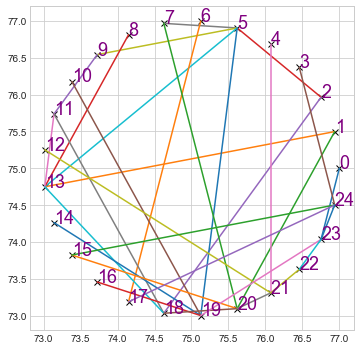

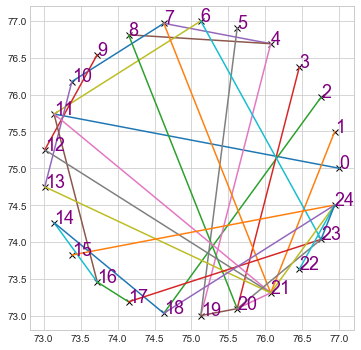

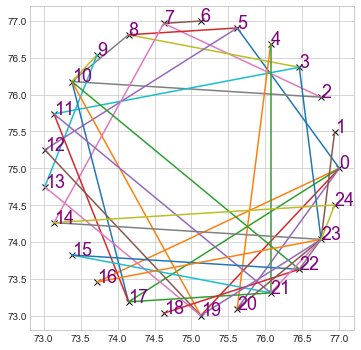

In [39]:
init()
assess_connectivity()

In [40]:
start_time = datetime.datetime.now()

In [41]:
if members_per_generation > 1:
    for i in range(0, generations):
#     i = 0
#     while i < fittest_swarm_list[0][len(fittest_swarm_list[0])-1] + patience:
#         i += 1
        print(i, end=" ")
        smart_scatter()
        population.sort(key=lambda x: x.fitness, reverse=True)
        print(population)
        if i >= 30 :
            assess_connectivity()
        kill_off_the_weak()
        is_new_fittest = check_for_fittest()
        #mingle_the_genes()
        asexually_reproduce()
        if is_new_fittest:
            fittest_swarm_list[1].append(fittest_swarm.fitness)
            fittest_swarm_list[0].append(i)
        else:
            population.append(copy.deepcopy(fittest_swarm))
        if i != generations - 1: 
            reset_population()
            mutate_population()
else:
    i = 0
    while i < fittest_swarm_list[0][len(fittest_swarm_list[0])-1] + patience:
        print(i, end=" ")
        i += 1
        smart_scatter()
        population.sort(key=lambda x: x.fitness, reverse=True)
        print(population)
        if check_for_fittest():
            fittest_swarm_list[1].append(fittest_swarm.fitness)
            fittest_swarm_list[0].append(i)
        reset_population()
        mutate_population()

0 [398.35538710536287, 396.01112131343655, 384.3879906443329]
NEW FITTEST: 398.35538710536287
0:00:00.873703
MUTS:  77
1 [399.31301685429975, 394.1517140441159]
NEW FITTEST: 399.31301685429975
0:00:01.579778
MUTS:  86
2 [401.330429424738, 391.9894023810622]
NEW FITTEST: 401.330429424738
0:00:02.291876
MUTS:  82
3 [401.7226077711617, 397.6671437273833]
NEW FITTEST: 401.7226077711617
0:00:03.019932
MUTS:  93
4 [401.096263287788, 388.5724630545076]
MUTS:  112
5 [408.4716823764666, 395.7705332064717, 390.47717511093384]
NEW FITTEST: 408.4716823764666
0:00:04.909883
MUTS:  71
6 [402.0474732980948, 397.54898656828436]
MUTS:  138
7 [406.86747710637405, 393.0810716008142, 388.0508949784181]
MUTS:  105
8 [404.3706465601921, 400.76497014211253, 391.2943453386533]
MUTS:  121
9 [404.4470483407529, 396.8608665665113, 391.5717892872357]
MUTS:  117
10 [406.1881819645462, 399.52951035690717, 389.8030656304488]
MUTS:  130
11 [419.6122773555202, 394.15037544927884, 390.6851189151226]
NEW FITTEST: 419.61

MUTS:  133
106 [437.9277242766558, 432.0863218273383, 416.80159930639803]
NEW FITTEST: 437.9277242766558
0:02:39.620155
MUTS:  78
107 [430.28978838091035, 429.5461165212984]
MUTS:  120
108 [430.19151135559434, 429.84920258075937, 426.14411459736687]
MUTS:  123
109 [431.4358490744701, 425.2682267186885, 423.69026891904696]
MUTS:  128
110 [434.1258442636889, 426.40237188533627, 422.535725785745]
MUTS:  120
111 [439.230213991785, 430.7198083931376, 429.5970012917421]
NEW FITTEST: 439.230213991785
0:02:48.149419
MUTS:  82
112 [428.3620044083928, 422.62091510402286]
MUTS:  130
113 [430.48170848809514, 425.69952963535167, 422.6013403864965]
MUTS:  122
114 [421.6923030869849, 416.8825379724125, 410.3421638006216]
MUTS:  133
115 [431.31032242663576, 424.4446314391287, 420.7038135870683]
MUTS:  104
116 [428.0737274486514, 425.76591951648015, 423.7027383377324]
MUTS:  123
117 [419.5609145924727, 418.12232286990525, 417.5724967370632]
MUTS:  126
118 [437.5683308858497, 428.8171689816734, 416.0506

MUTS:  113
215 [427.15496544106554, 425.22946969400715, 423.0121284172733]
MUTS:  121
216 [440.4669662900498, 432.397088059339, 423.2691565177779]
MUTS:  127
217 [444.9397088499745, 443.33654292005957, 425.7553708346103]
MUTS:  119
218 [444.7837812638418, 438.6296926605813, 434.8346317758988]
MUTS:  110
219 [444.4830685167762, 444.17800030159697, 433.28012148454087]
MUTS:  127
220 [440.3844952326527, 439.94031666873826, 430.9023274748914]
MUTS:  125
221 [436.921612654903, 435.3488610111807, 434.3411650789651]
MUTS:  113
222 [437.0367094475059, 435.89070361640427, 417.16753836964557]
MUTS:  123
223 [440.5515131250315, 433.22693749418556, 431.85856046895896]
MUTS:  127
224 [438.8240776991707, 437.52433161221524, 425.20298392870234]
MUTS:  114
225 [434.07325707956096, 431.4121478014135, 418.9049976306838]
MUTS:  116
226 [441.0733848463519, 438.57433203246575, 438.4254180506154]
MUTS:  127
227 [437.82141820765804, 436.24860092013023, 434.78311736036574]
MUTS:  127
228 [432.3210268786519, 4

In [42]:
print(datetime.datetime.now() - start_time)

0:09:14.475451


445.95864983156235


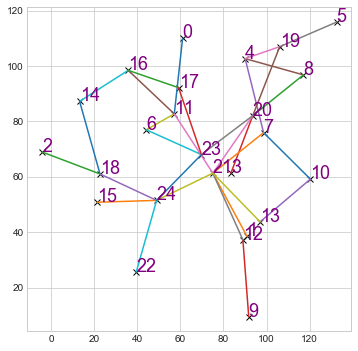

In [43]:
#check_drone_coverage(fittest_swarm)
draw_scene(fittest_swarm)

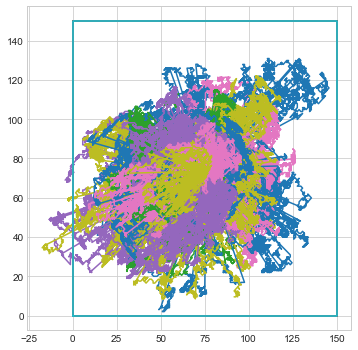

In [44]:
# Draws a visualization for the swarm path   
for drone in fittest_swarm.drones:
    set_map_size()
    plt.plot(drone.path[0], drone.path[1])
    population[0].the_map.draw_map()

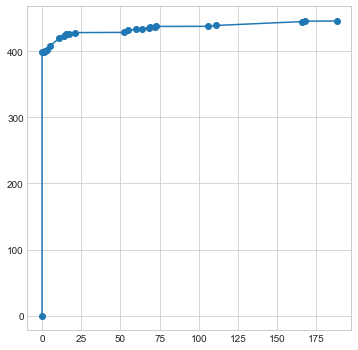

In [45]:
set_map_size()
plt.plot(fittest_swarm_list[0], fittest_swarm_list[1], '-o')

445.95864983156235
445.95864983156235
445.95864983156235


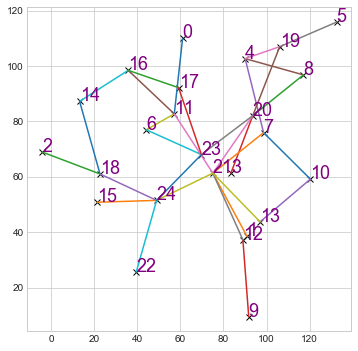

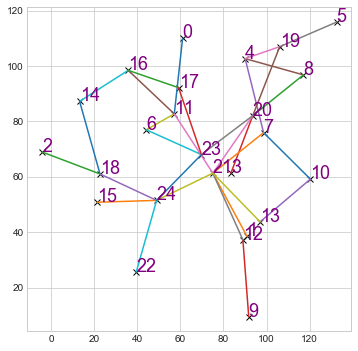

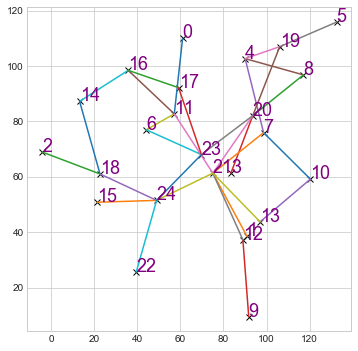

In [46]:
assess_connectivity()
plot_population()